In [144]:
import imblearn
import random
import numpy as np
from sklearn.decomposition import PCA
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
import matplotlib
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import sklearn.metrics
from sklearn.metrics import accuracy_score

n_comp = 25
q = [0, 0.1, 0.9, 1]

In [145]:
y_path = Path.cwd().parent.joinpath("Data", "Split", "train_labels.npy")
y_train = np.load(y_path)
bins = np.quantile(y_train, q =  q)
y_train = pd.qcut(x=y_train, q= q, labels=[-1, 0, 1])
np.unique(y_train)

array([-1,  0,  1])

In [146]:
x_path = Path.cwd().parent.joinpath("Data", "Split", "train_features.npy") #temperature average of autmn per year
x_train=np.load(x_path)

In [147]:
# Test
print(np.unique(y_train))
print(x_train)

[-1  0  1]
[[ 0.51519269  1.13874471  1.33152628 ...  1.58121669  1.64707494
   1.71492434]
 [-0.06682462 -0.46294659 -0.80747449 ... -0.60453928 -0.57841688
  -0.55541831]
 [-0.85686767 -1.24928701 -1.04056776 ...  1.08864331  1.08122003
   1.08038592]
 ...
 [ 0.66258782  0.38447481 -0.00505118 ...  1.12904131  1.15510249
   1.1772933 ]
 [-1.09121192 -0.07895684  0.2210492  ...  0.13585594  0.11344573
   0.08935153]
 [ 0.93628663  0.60988671  0.02503903 ... -0.85366362 -0.85495549
  -0.85414285]]


In [149]:
random.seed(1234)
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(-1, 640), (0, 640), (1, 640)]


In [150]:
temp = x_resampled[:, np.arange(0, 2322)]
pres = x_resampled[:, np.arange(2322, 4644)]

In [193]:
n_comp = 5
pca= PCA(n_components=n_comp)
temp_trans= pca.fit_transform(temp)
sum(pca.explained_variance_ratio_)
pca_pres=PCA(n_components=n_comp)
pres_trans = pca_pres.fit_transform(pres)
print(pca_pres.explained_variance_ratio_)
print(pca_pres.explained_variance_ratio_.sum())
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())
print(pres_trans.shape)
print(temp_trans.shape)
pca_train = np.concatenate([temp_trans, pres_trans], axis=1)

[0.31704377 0.17996644 0.07579645 0.06900901 0.06314006]
0.7049557361201018
[0.15152003 0.09096898 0.08529144 0.06780705 0.06388484]
0.4594723395079059
(1920, 5)
(1920, 5)


In [194]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#random_grid = {'n_estimators': n_estimators}
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
#                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(pca_train, y_resampled)

In [195]:
#n_estimators = rf_random.best_params_['n_estimators']
n_estimators = 500
print(n_estimators)
base_model = RandomForestClassifier(n_estimators = n_estimators)
base_model.fit(pca_train, y_resampled)

500


RandomForestClassifier(n_estimators=500)

In [37]:
#scores=cross_val_score(base_model, pca_train, y_resampled, cv=2,n_jobs=-1)
#scores

array([0.98796296, 0.99814815])

In [196]:
# TEST: 
y_path = Path.cwd().parent.joinpath("Data", "Split", "test_labels.npy")
y_test=np.load(y_path)
y_test = pd.cut(y_test, bins = bins, labels = [-1, 0, 1])
x_path = Path.cwd().parent.joinpath("Data", "Split", "test_features.npy") #temperature average of autmn per year
x_test=np.load(x_path)

# PCA 
temp_test = x_test[:, np.arange(0, 2322)]
pres_test = x_test[:, np.arange(2322, 4644)]
temp_test_tf = pca.transform(temp_test)
pres_test_tf = pca_pres.transform(pres_test)
pca_test = np.concatenate([temp_test_tf, pres_test_tf], axis=1)

In [197]:
pred = base_model.predict(pca_test)
acc = accuracy_score(pred, y_test)
print(pred)
print(y_test)
print(acc)

[ 0  0  0  0  0  0  0  0 -1  0  1  0  1  0  0  1  0  0  1  0  0  0  0  0
  0  0  0  0 -1  0  1 -1  0  0  0  0  0  0 -1  1  1  0  0  0 -1  0  1  0
  0  0  0 -1  1  1  1  0  1 -1  0  0  0  0  0  0  0  0  1  0  1  0  1  0
 -1  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
[0, 1, 0, 0, 0, ..., 0, 0, -1, 0, 0]
Length: 100
Categories (3, int64): [-1 < 0 < 1]
0.58


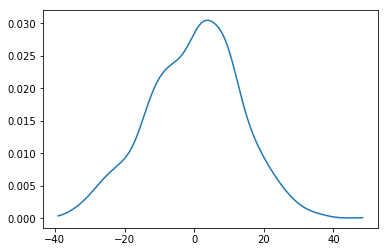

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
data = temp_trans[:,1]
mx = data.max()
mn = data.min()
density = gaussian_kde(data)
xs = np.arange(mn, mx, 0.1)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()

[0 0 0 ... 1 1 1]


{'whiskers': [<matplotlib.lines.Line2D at 0x7efc48b02a20>,
 'caps': [<matplotlib.lines.Line2D at 0x7efc48b0d0f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efc48b02860>],
 'medians': [<matplotlib.lines.Line2D at 0x7efc48b0d780>],
 'fliers': [<matplotlib.lines.Line2D at 0x7efc48b0dac8>],
 'means': []}

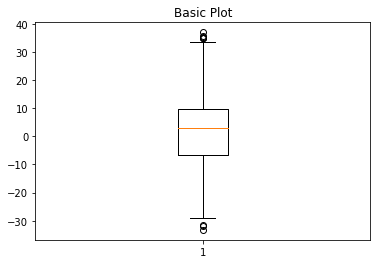

In [23]:
print(y_resampled)
data = temp_trans[y_resampled == -1, 1]
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data)


{'whiskers': [<matplotlib.lines.Line2D at 0x7efc48ad3f28>,
 'caps': [<matplotlib.lines.Line2D at 0x7efc48adc5f8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efc48ad3dd8>],
 'medians': [<matplotlib.lines.Line2D at 0x7efc48adcc88>],
 'fliers': [<matplotlib.lines.Line2D at 0x7efc48adcfd0>],
 'means': []}

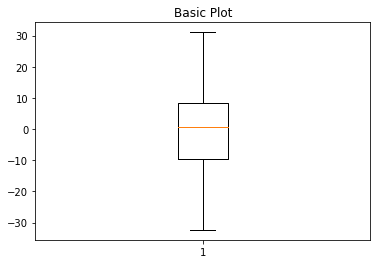

In [24]:
data = temp_trans[y_resampled == 1, 1]
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data)

{'whiskers': [<matplotlib.lines.Line2D at 0x7efc48a9fc88>,
 'caps': [<matplotlib.lines.Line2D at 0x7efc48aa7358>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efc48a9fb38>],
 'medians': [<matplotlib.lines.Line2D at 0x7efc48aa79e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7efc48aa7d30>],
 'means': []}

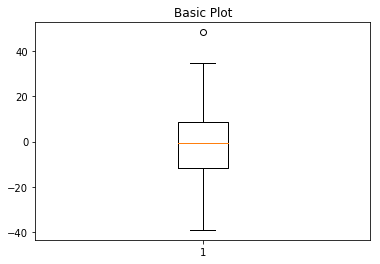

In [25]:
data = temp_trans[y_resampled == 0, 1]
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data)